In [1]:
%matplotlib inline

# Exercise

**Task**

* Get the data for dataset `rd_e_berdindr2` from the Eurostat API for all NACE activities as a percentage of GDP
* Read the data into a pandas dataframe
* Calculate the total expenditure across countries each year
* Plot it

---
**Links**

* [Query builder](https://ec.europa.eu/eurostat/web/json-and-unicode-web-services/getting-started/query-builder) - This will help you build a query
* [Data Explorer](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=rd_e_berdindr2&lang=en) - This will let you explore the dataset
* [Metadata](https://ec.europa.eu/eurostat/cache/metadata/en/rd_esms.htm) - Description of the data

---
**Hint**

If you look at the data-explorer/metadata/response you will see that there won't be a `payload['value']` for every possible index - there is missing data!
To deal with this we can create a quick workaround by using a `defaultdict` from the `collections` library.
A default dict takes a function and a dictionary as arguements. When a value is looked up in the dictionary that isn't found it calls and returns the function passed to `defaultdict`. 

Below we create a `defaultdict` that returns `None` for indexes that aren't there and builds a new dictionary that fills in the missing data:

``` python
from collections import defaultdict
n = len(index)  # Length of our index
def return_none():
    return None
d = defaultdict(return_none, payload['value'])  # Build default dict
values = [
    d[str(i)]  # Lookup `i` in dictionary
    for i in range(n)  # Numberical indexes
]
```

**Use this *somewhere* in your solution**

NOTE: We use `str(i)` because the keys of the dictionaries are strings not integers so we need to convert

---
**EXTENSION**

Pick another dataset from Eurostat, fetch it and use a [`merge`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html) operation to join the two datasets together.

# Solution

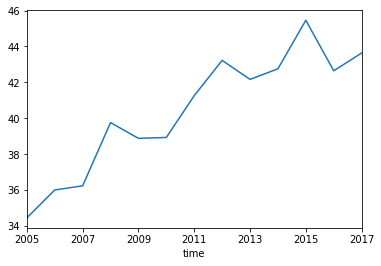

In [2]:
from collections import defaultdict
import requests
import pandas as pd

# Make the request
url = ('http://ec.europa.eu/eurostat/wdds/rest/data/v2.1/json/en'
       '/rd_e_berdindr2?precision=1&unit=PC_GDP&nace_r2=TOTAL'
       )
try:
    response = requests.get(url)
    response.raise_for_status()  # Gives an error if not successful
except:
    print(response.reason)
    raise

# Parse into JSON
payload = response.json()

# Define the index from `payload['dimension']`
index = pd.MultiIndex.from_product(
    [payload['dimension'][k]['category']['index'] for k in payload['id']]
    , names = payload['id']
)
index

# Fill in gaps in data
n = len(index)
def return_none():
    return None
d = defaultdict(return_none, payload['value'])
values = [d[str(i)] for i in range(n)]

# Read into dataframe, manipulate and plot
(pd.DataFrame(values, index=index)
    # Make dataframe wider
   .unstack('time')
   .droplevel(0, axis=1)
    # Get totals
   .sum()
    # Plot
   .plot()
)